<a href="https://colab.research.google.com/github/SBShimm/Aiffel/blob/master/%20exploration/Exploration12_SB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 뉴스기사 요약해보기

필요한 모듈 및 패키지를 설치하여 불러옵니다.

In [1]:
!pip install summa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 2.7 MB/s 
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54412 sha256=ee61483db6f36ae130baa20df3e322c8f513fe92afa9524fe9abcc865b8c935f
  Stored in directory: /root/.cache/pip/wheels/29/64/ac/7b443477588d365ef37ada30d456bdf5f07dc5be9f6324cb6e
Successfully built summa


In [2]:
import importlib_metadata as metadata
import nltk
import os
import re
import tensorflow as tf
import summa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

사용할 데이터는 뉴스 기사 데이터입니다. 아래 코드를 통해 다운로드하여 불러옵니다.

In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
data.sample(10)

,headlines,text
3584,Maharashtra group demands action against virgi...,The Maharashtra Andhashraddha Nirmoolan Samiti...
12164,Philippine Prez sacks all top customs official...,"Philippine President Rodrigo Duterte, whose wa..."
30908,"BJP called me, said we'll give you a ministry:...","Congress leader Amaregouda Patil, who won from..."
68437,"Surgical strikes a message, could follow if re...",Army Chief General Bipin Rawat on Monday said ...
8424,Ex-footballer unaware of 'Wolf of Wall Street'...,Former South African footballer Mike Mangena h...
42754,Kidnapped Nigerian schoolgirls freed by Boko H...,Boko Haram militants on Wednesday released ove...
86784,Air India staff to hold surprise midnight chec...,Air India Chief Ashwani Lohani has instructed ...
89559,"SoftBank posts Ã¢ÂÂ¹9,000 cr loss on Snapdeal...",Japanese investor SoftBank Group has reported ...
58523,8 dead as Cyclone 'Ockhi' hits southern Kerala...,At least four people in Tamil Nadu and four in...
95149,Bangladeshi captain Mortaza announces retireme...,Bangladesh cricket team's limited overs captai...


In [5]:
len(data)

98401

총 98401개의 데이터를 가집니다. 이 중에서 중복데이터가 있는지 확인해 봅니다.

In [6]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


text가 달라도 headlines는 같을 수 있기 때문에 text를 기준으로 중복 데이터를 제거합니다.

In [7]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


다음은 빈 값이 있는지 확인해 봅니다.

In [8]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


빈 값은 하나도 없습니다.  
다음은 데이터 정규화를 위해 정규화 사전을 준비합니다.

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


다음은 불용어를 제거해 줍니다.  
불용어는 텍스트에 자주 등장하지만 자연어 처리에 도움이 되지 않는 단어들을 말합니다.  
NLTK에서 제공하는 불용어 리스트를 참조하도록 하겠습니다.

In [10]:
nltk.download('stopwords')
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


이 외에 추가적인 전처리로 소문자화, html 태그 제거, 정규 표현식을 통한 특수문자 제거를 해줍니다.  

In [11]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

여기서 text만 불용어를 제거해 주고, headlines는 제거하지 않습니다. 이제 각각 text와 headlines에 대한 전처리를 해줍니다.

In [12]:
# clean_text = []
# clean_headlines = []

# for s in data['text']:
#     clean_text.append(preprocess_sentence(s))

In [13]:
# for s in data['headlines']:
#     clean_headlines.append(preprocess_sentence(s, False))

In [14]:
# print(len(clean_text))
# print(clean_text[:5])

In [15]:
# print(len(clean_headlines))
# print(clean_headlines[:5])

전처리가 되었습니다. 전처리 과정이 오래걸리니까 csv파일로 저장해 두었다가 두고두고 사용합시다.

In [16]:
#data['text'] = clean_text
#data['headlines'] = clean_headlines

#data.replace('', np.nan, inplace=True)
#data.to_csv('/content/drive/MyDrive/Colab/Datasets/news_headlines/news_summary_more.csv', mode='w')

In [17]:
data = pd.read_csv('/content/drive/MyDrive/Colab/Datasets/news_headlines/news_summary_more.csv')

In [18]:
data.sample(5)

,Unnamed: 0,headlines,text
11775,11775,take evening walk to see delhi air pollution s...,worsening air quality delhi supreme court mond...
5655,5655,ram temple should be built by mutual consent n...,union minister nitin gadkari tuesday said ram ...
6685,6685,bodies of friends who disappeared yrs ago in h...,bodies two mountaineering friends kristinn nar...
20665,20665,indian swimmer misses asian games bronze by se...,indian swimmer virdhawal khade finished fourth...
32081,32082,dial for government help if stuck in thunderstorm,indian meteorological department issued thunde...


성공적으로 불러왔습니다. Unnamed:0은 중복 제거전 인덱스가 들어가는 것 같습니다.  
text와 headlines만 사용하도록 합시다.

In [19]:
data = data[['text','headlines']]

In [20]:
data.sample(5)

,text,headlines
43755,according us atmospheric weather agency noaa m...,minor solar flare expected today may disrupt p...
10656,days rjd supremo lalu prasad yadav son tej pra...,think tej pratap is in varanasi wants solitude...
65171,police conducted raids several market areas ar...,two men arrested for selling firecrackers in g...
71639,nigerian national arrested greater noida alleg...,nigerian man arrested for illegal stay in grea...
86138,rented air coolers first installed later remov...,rented coolers put in hospital for yogi visit ...


In [21]:
data.isnull().sum()

text         0
headlines    0
dtype: int64

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


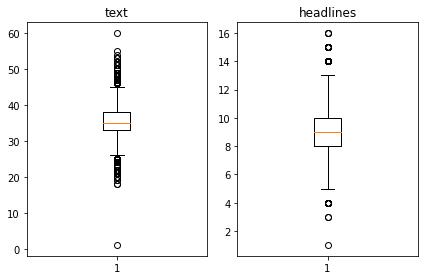

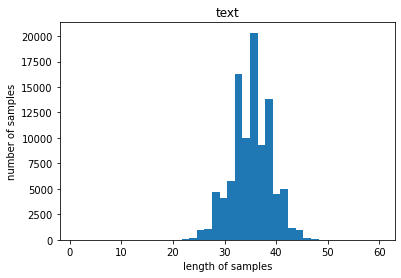

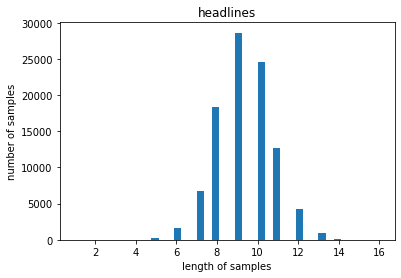

In [22]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

text의 경우 30\~40의 데이터가 대부분이고 최대가 60정도로 보이네요. headlines는 최대 16의 값이지만 대부분 8~11에 데이터가 몰려있습니다.  
이에 따라 임의로 길이를 지정합니다.

In [23]:
text_max_len = 45
headlines_max_len = 12

아래 함수로 설정한 길이 기준 몇%의 데이터를 포함하는지 확인할 수 있습니다.

In [24]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [25]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


대부분의 데이터를 포함하는 것으로 보입니다.  이제 이 길이를 기준으로 데이터를 제외하겠습니다.

In [26]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 96871


이제 학습시킬 데이터인 headlines에 start와 end token을 추가합니다.

In [27]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,text,headlines,decoder_input,decoder_target
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


In [28]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

이제 트레인, 테스트 데이터를 직접 분리합시다. encoder_input과 형태가 같은 정수 시퀀스를 만들어 주고 이 시퀀스를 이용해 데이터의 샘플 순서를 정의하여 샘플을 섞어줍니다. 

In [29]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[41580 55487 18727 ... 23297 79357 91168]


In [30]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

다음은 0.2의 비율로 validation set의 크기를 지정합니다.

In [31]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19374


In [32]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 77497
훈련 레이블의 개수 : 77497
테스트 데이터의 개수 : 19374
테스트 레이블의 개수 : 19374


성공적으로 훈련 데이터와 테스트 데이터를 분리하였습니다.

이제 각 데이터들을 단어 집합으로 만들어 줍니다. 학습하기 쉽도록 단어를 정수로 매핑해야 합니다.

In [33]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [34]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 68906
등장 빈도가 6번 이하인 희귀 단어의 수: 46962
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21944
단어 집합에서 희귀 단어의 비율: 68.1537166574754
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5170117268070165


encoder_input에는 총 6만9천개의 단어가 있고 6번 이하로 등장하는 단어가 68%나 되지만, 전체 등장 빈도로 따지면 3.5%밖에 되지 않습니다.  
등장 빈도가 6회 이하인 단어들은 훈련 데이터에서 제거해 주도록 합니다.  
전체에서 희귀 단어 수를 빼면 22000이니 토큰화 단어 집합 크기를 22000으로 제한합니다.

In [35]:
src_vocab = 22000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [36]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1618, 2, 59, 686, 7609, 5556, 28, 968, 257, 956, 315, 1681, 7204, 968, 546, 16, 47, 2854, 4838, 318, 499, 443, 209, 829, 4445, 2854, 4375, 32, 5556, 2517, 2591, 396, 145, 11178, 5766, 16, 121, 1618, 2], [11, 1676, 868, 233, 369, 1159, 306, 765, 59, 8083, 518, 857, 1193, 2091, 199, 4376, 306, 110, 868, 407, 414, 709, 10914, 199, 193, 1222, 2855, 3858, 233, 226, 1643, 644, 11, 100, 306], [2, 1159, 1288, 883, 558, 354, 910, 53, 7952, 254, 69, 7952, 40, 953, 7721, 3710, 7952, 1473, 1546, 9393, 2561, 392, 6917, 1318, 2, 2450, 354, 910, 5598, 119, 2008, 1177, 883, 558]]


In [37]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [38]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29911
등장 빈도가 5번 이하인 희귀 단어의 수: 19581
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10330
단어 집합에서 희귀 단어의 비율: 65.46421049112367
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.7194643443845665


여기도 마찬가지로 등장 빈도 5번 이하의 단어는 65%이지만 전체 기준 4.7%입니다. 단어를 10000개로 제한하여 다시 토큰화 해줍니다.

In [39]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 992, 9, 1341, 4111, 1991, 17, 4970, 289], [1, 493, 513, 2490, 106, 6, 113, 686, 4, 1356], [1, 9, 166, 86, 3358, 1281, 269, 4, 66, 5858], [1, 527, 400, 16, 10, 2235, 106, 336, 6], [1, 42, 79, 5373, 2760]]
target
decoder  [[992, 9, 1341, 4111, 1991, 17, 4970, 289, 2], [493, 513, 2490, 106, 6, 113, 686, 4, 1356, 2], [9, 166, 86, 3358, 1281, 269, 4, 66, 5858, 2], [527, 400, 16, 10, 2235, 106, 336, 6, 2], [42, 79, 5373, 2760, 2]]


이제 토큰화를 하면서 잘린 단어들로 인해 빈 샘플이 되었을 가능성이 있는 데이터들을 제거해 주도록 합니다.

In [40]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 77497
훈련 레이블의 개수 : 77497
테스트 데이터의 개수 : 19374
테스트 레이블의 개수 : 19374


삭제할 게 없네요?  
다음은 모든 샘플의 병렬 처리를 위한 길이 맞추기 작업입니다.  
zero-padding을 해줍니다.

In [41]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen= headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## 2. 모델 설계하기
길고 긴 전처리가 끝났습니다. 다음은 모델을 설계하도록 합시다. 

In [42]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

먼저 인코더입니다. 인코더에서는 LSTM을 3개 사용합니다.

In [43]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [44]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 45)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 45, 128)      2816000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 45, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

어텐션 매커니즘을 추가합니다. TensorFlow에서 구현된 어텐션 함수를 가져와서 디코더 출력층에 결합하여 줍니다.

In [45]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 45)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 45, 128)      2816000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 45, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

이제 데이터를 학습시켜 줍니다.

In [46]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=30)

Epoch 1/30
303/303 [==============================] - 36s 78ms/step - loss: 5.6136 - val_loss: 5.1749
Epoch 2/30
303/303 [==============================] - 22s 73ms/step - loss: 5.0299 - val_loss: 4.8032
Epoch 3/30
303/303 [==============================] - 22s 73ms/step - loss: 4.6942 - val_loss: 4.5383
Epoch 4/30
303/303 [==============================] - 22s 73ms/step - loss: 4.4239 - val_loss: 4.3452
Epoch 5/30
303/303 [==============================] - 22s 73ms/step - loss: 4.2120 - val_loss: 4.2031
Epoch 6/30
303/303 [==============================] - 22s 73ms/step - loss: 4.0438 - val_loss: 4.0890
Epoch 7/30
303/303 [==============================] - 22s 73ms/step - loss: 3.8982 - val_loss: 4.0100
Epoch 8/30
303/303 [==============================] - 22s 73ms/step - loss: 3.7687 - val_loss: 3.9380
Epoch 9/30
303/303 [==============================] - 22s 73ms/step - loss: 3.6573 - val_loss: 3.8733
Epoch 10/30
303/303 [==============================] - 22s 73ms/step - loss: 3.552

이전에 지정해준 Early Stopping 조건에 의해 val_loss가 연속으로 줄어들지 않아서 학습을 종료하였습니다.  
이제 loss의 변화를 시각화 해보겠습니다.

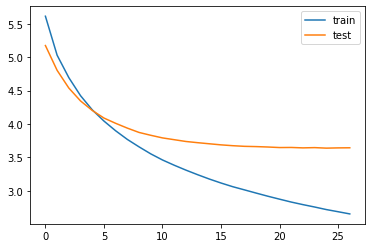

In [47]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

다음은 정수 <->단어간의 변환을 쉽게 해줄 사전을 생성해 줍니다.

In [48]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

이제 모델을 테스트하기 위한 준비들을 할 차례입니다.  
인퍼런스 모델 구현

In [49]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

어텐션 매커니즘 사용하는 출력층

In [50]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [51]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 3. 모델 테스트하기  
이전에 준비했던 작업을 바탕으로 원문을 요약해봅시다.

In [52]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [53]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : nasa juno spacecraft successfully completed flyby km jupiter great red spot marking closest approach man made object storm large enough fit three earths raw images spacecraft latest flyby posted coming days nasa said juno launched august orbiting jupiter year 
실제 요약 : closest ever over jupiter great red spot completed 
예측 요약 :  nasa spacecraft completes jupiter on jupiter jupiter


원문 : swiss researchers created prototype ultra thin concrete roof also generate solar power self supporting curved roof heating cooling inner concrete layer second exterior layer concrete structure roof thin film cells would installed solar power generation 
실제 요약 : thin concrete roof can generate solar power 
예측 요약 :  solar wind hai to be made by solar


원문 : men gujarat started social media campaign posting selfies protest anti dalit violence state users posted selfies social media sites like instagram twitter using comes two dalit men allegedly beaten two separate incidents members rajput community s

처음엔 원문에 있던 단어들이 나오지만 뒤로 갈수록 이상한 단어를 가지고 오는것 같다.

## 4. 추출적 요약  
추출적 요약은 원문에서 문장들을 추출해서 요약하는 방식입니다.  
Summa의 summarize 함수를 통해 쉽게 할 수 있습니다.  
지금까지 사용했던 전처리가 된 text는 문장을 구분하는 기호 같은 것들이 모두 사라져서 사용할 수 없으니 원본 데이터를 다시 불러와서 사용합시다.

In [54]:
import requests
from summa.summarizer import summarize

In [55]:
data_one = pd.read_csv('/content/news_summary_more.csv', encoding='iso-8859-1')

각 문장의 길이가 그렇게 길지 않기 때문에 ratio는 0.4로 하겠습니다. 이렇게 크게 해도 문장이 많지 않은 원문은 요약하지 못하는 경우가 몇가지 보입니다. 

In [56]:
for i in range(50, 100):
  print('{}번 째 문장'.format(i-49), data_one['text'][i])
  print('추출적 요약 :',summarize(data_one['text'][i], ratio=0.4))
  print()

1번 째 문장 Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.
추출적 요약 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).

2번 째 문장 US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 and 905 commercial aircraft in 2019. Boeing retained its position as the world's largest planemaker for the seventh straight year, delivering 806 aircraft in 2018. 
추출적 요약 : Boeing retained i

문장을 몇가지만 뽑아오니 요약은 되겠지만 핵심 내용이 포함되지 않는 경우가 있을 수 있습니다.  
모델을 이용한 요약과 비교해 보려고 했는데 전처리 데이터는 indices를 통해 순서를 섞어주는 과정을 거쳤기 때문에 원본 데이터와 순서가 달라서 비교할 수가 없었다.

5. 회고
- 전처리 한 원문으로 계속 추출적 요약에 넣어봤는데 동작을 안해서 왜 그런가 했더니 추출적 요약은 문장 전체 원문에서 문장을 뽑아서 요약하는 거니까 전처리 된 원문에선 문장을 구분할 수 없으니 동작을 안 할 수 밖에 없는 거였다는 생각이 들었다.
- NLP는 역시 어려운 것 같다.. 
- 전처리한걸 저장해뒀다 사용하니 시간도 절약되고 편안하다. 애용해야겠다